In [1]:
import pandas as pd
import csv
import numpy as np
import re
import string
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
import sys
from matplotlib import pyplot as plt
from nltk.stem.porter import PorterStemmer
import math
import warnings
warnings.filterwarnings('ignore')
sys.setrecursionlimit(100000)

# Cluster

In [2]:
videos = []
with open("sentence_clusters_fastcluster_nonbinary_all.tsv", 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    for row in reader:
        videos.append([row[0], row[1], row[2], row[3], row[4]])
        
videos_en_new = pd.DataFrame(videos, columns=['id', 'description', 'channelTitle', 'sentence', 'clusterNum'])
del videos

In [3]:
num_coupon_codes = 0
for i, row in videos_en_new.iterrows():
    if row['clusterNum'] == str(68):
        num_coupon_codes += 1
        videos_en_new.at[i, 'isCoupon'] = 1
    else:
        videos_en_new.at[i, 'isCoupon'] = 0

In [4]:
print videos_en_new.shape

(77706, 6)


In [5]:
print num_coupon_codes

177


In [6]:
positives = []
for i, row in videos_en_new.iterrows():
    if row['isCoupon'] == 1:
        positives.append([row.id, row.description, row.channelTitle, row.sentence, row.clusterNum, row.isCoupon])
        
positiveDF = pd.DataFrame(positives, columns=['id', 'description', 'channelTitle', 'sentence', 'clusterNum', 'isCoupon'])
del positives
print(positiveDF.shape)

(177, 6)


In [7]:
stemmer = PorterStemmer()

def tokenize(line):
    if (line is None):
        line = ''
    printable = set(string.printable)
    line = ''.join(filter(lambda x: x in printable, line)) 
    stopwords = nltk.corpus.stopwords.words('english')

    tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]*\'[a-zA-Z]*|\w+')
    
    tokens = []
    
    line = re.sub(r'(http[s]?://|www.)(?:[a-zA-Z]|[0-9]|[$-_@.&+]*|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))*', '', line).lower()
    tokens.extend(tokenizer.tokenize(line))
    
    tokens_ = [f.strip(string.punctuation) for f in tokens]
    tokens_ = [f for f in tokens_ if f != '' and f not in stopwords and len(f) != 1]
    tokens_ = [f for f in tokens_ if not (f.isdigit() or f[0] == '-' and f[1:].isdigit())]
    tokens_ = [stemmer.stem(f) for f in tokens_]

    return tokens_


# Run once

In [8]:
# There are few coupon codes compared to the size of the dataset
# Need to shrink the negative sample size in our training dataset
sample_set = videos_en_new.sample(n=1000)

In [9]:
sample_set.shape

(1000, 6)

In [10]:
training_set = sample_set.append(positiveDF)
training_set.shape

(1177, 6)

In [11]:
y = training_set.isCoupon

In [12]:
countVec = CountVectorizer(tokenizer=tokenize, min_df=5).fit(training_set['sentence'])

In [13]:
lineVec = countVec.transform(training_set['sentence'])

In [14]:
classifier = SVC(kernel="linear", C=0.05)

In [15]:
classifier.fit(lineVec, training_set['isCoupon'])

SVC(C=0.05, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [16]:
scores = cross_val_score(classifier, lineVec, y, cv=20)
print 'Cross-validated scores:', scores

Cross-validated scores: [1.         1.         1.         1.         0.96610169 0.98305085
 0.98305085 0.98305085 1.         1.         1.         1.
 1.         0.98305085 1.         1.         1.         0.93220339
 1.         1.        ]


In [17]:
predictions = cross_val_predict(classifier, lineVec, y, cv=6)
accuracy = metrics.r2_score(y, predictions)
print 'Cross-Predicted Accuracy:', accuracy

Cross-Predicted Accuracy: 0.9338102147090911


In [18]:
precision, recall, threshold = metrics.precision_recall_curve(y, predictions)
print precision
print recall 
print threshold

[0.15123195 1.         1.        ]
[1.         0.94382022 0.        ]
[0. 1.]


In [19]:
print 'F1 Score:', metrics.f1_score(y, predictions)

F1 Score: 0.9710982658959537


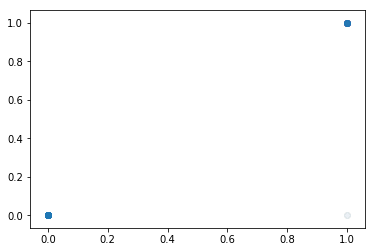

In [20]:
plt.scatter(y, predictions, alpha=0.007)

In [21]:
features = countVec.get_feature_names()
string = "["
for item in features:
    temp = item
    if item[0:2] == "b'":
        temp = item[2:]
    string += '"' + temp + '",'
string = string[0:-1] + "];"
#print string

In [22]:
b = classifier.coef_.toarray()[0]
print b[countVec.get_feature_names().index("code")]
string = "["
for item in b:
    if item == 0:
        string += "0, "
    else:
        string += '%1.20f' % item + ", "
string = string[0:-2] + "];"
#print string

1.912885752578094


In [23]:
string = "["
for i, row in training_set.iterrows():
    sentence = row.sentence
    string += repr(sentence[2:]) + ', '
#print string[0:-2] + "]"